# Análisis de Clustering en Datos preprocesados con FFT
### Objetivo
Implementar análisis de clustering en el dominio de frecuencia para verificar si existe separación evidente entre las clases de daño (N1, N2, N3) usando pares sincronizados de señales (S2, S1).

### Contexto del Proyecto
#### Estado Actual
- Datos raw: 34 especímenes, cada uno con 1-3 mediciones (pares S1/S2)
- Etiquetas: nivel_damage.csv mapea especímenes → {N1: 18, N2: 12, N3: 4}

#### Concepto Clave
- **1 datapoint = 1 par (S2, S1)** de una medición sincronizada
- El daño se manifiesta en la **relación entre S2 y S1**, no en señales individuales
- S2 = excitación basal, S1 = respuesta estructural filtrada por el aislador

In [375]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Configuración de plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

print("📦 Librerías cargadas correctamente")

📦 Librerías cargadas correctamente


## 1. Carga de Pares de Señales (S2, S1)

Cargamos las señales raw de vibración como pares sincronizados:
- **S2**: Sensor en base (excitación)
- **S1**: Sensor superior (respuesta)

In [376]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [377]:
# Importar función de utilidades
sys.path.append('../utils')

# Importar logger de métricas
from metrics_logger import ClusteringMetricsLogger

# Inicializar logger
RESULTS_FILE = 'clustering_experiments.csv'
logger = ClusteringMetricsLogger(output_file=RESULTS_FILE)

print(f"📊 Logger inicializado: {RESULTS_FILE}")

📊 Logger inicializado: clustering_experiments.csv


In [378]:
from clustering_utils import load_paired_signals

# Configurar rutas
SIGNALS_DIR = '../../data/Signals_Raw/'
LABELS_CSV = '../../data/nivel_damage.csv'

print("🔧 Configuración:")
print(f"   📂 Directorio de señales: {SIGNALS_DIR}")
print(f"   📋 Archivo de etiquetas: {LABELS_CSV}")
print(f"   🎯 Especímenes a cargar: Solo base (A1, A2, ... sin -2, -3)")

🔧 Configuración:
   📂 Directorio de señales: ../../data/Signals_Raw/
   📋 Archivo de etiquetas: ../../data/nivel_damage.csv
   🎯 Especímenes a cargar: Solo base (A1, A2, ... sin -2, -3)


In [379]:
# Cargar pares de señales (S2, S1)
paired_data = load_paired_signals(
    signals_dir=SIGNALS_DIR,
    labels_csv=LABELS_CSV,
    base_specimens_only=True,  # Solo especímenes base (1 medición por aislador)
    target_length=60000,       # Estandarizar a 60,000 muestras (10 min @ 100Hz)
    verbose=True               # Mostrar progreso detallado
)

print(f"\n✅ Pares cargados exitosamente: {len(paired_data)}")

📋 PASO 1: Cargando etiquetas...
   ✓ Cargadas etiquetas para 71 especímenes

📂 PASO 2: Escaneando directorio ../../data/Signals_Raw/...
   ✓ Filtrado a 51 especímenes base (sin variantes -2, -3)

🔄 PASO 3: Cargando pares (S2, S1)...
   ✓ A1: 60,000 muestras → 60,000 (sin cambios) | N1 | Tipo B
   ✓ A10: 60,000 muestras → 60,000 (sin cambios) | N2 | Tipo C
   ✓ A11: 60,000 muestras → 60,000 (sin cambios) | N2 | Tipo C
   ✓ A12: 60,000 muestras → 60,000 (sin cambios) | N1 | Tipo C
   ✓ A13: 60,000 muestras → 60,000 (sin cambios) | N1 | Tipo C
   ✓ A14: 60,000 muestras → 60,000 (sin cambios) | N1 | Tipo B
   ✓ A15: 93,999 muestras → 60,000 (truncada) | N1 | Tipo nan
   ✓ A16: 86,499 muestras → 60,000 (truncada) | N1 | Tipo nan
   ✓ A17: 119,099 muestras → 60,000 (truncada) | N1 | Tipo nan
   ✓ A18: 104,199 muestras → 60,000 (truncada) | N1 | Tipo nan
   ✓ A19: 104,399 muestras → 60,000 (truncada) | N1 | Tipo nan
   ✓ A2: 60,000 muestras → 60,000 (sin cambios) | N1 | Tipo B
   ✓ A20: 99,49

### Inspección de los Datos Cargados

In [380]:
# Inspeccionar el primer par cargado
print("📋 ESTRUCTURA DE UN PAR (ejemplo con el primer espécimen):")
print("=" * 60)

first_pair = paired_data[0]

print(f"🆔 Specimen ID: {first_pair['specimen_id']}")
print(f"🏷️  Nivel de daño: {first_pair['nivel_dano']}")
print(f"🔧 Tipo de aislador: {first_pair['tipo']}")
print(f"📏 Longitud original: {first_pair['original_length']:,} muestras")
print(f"\n📊 Señal S2 (Sótano 2 - Base):")
print(f"   Shape: {first_pair['signal_S2'].shape}")
print(f"   Ejes: [N-S, E-W, U-D]")
print(f"   Min: [{first_pair['signal_S2'][:, 0].min():.6f}, {first_pair['signal_S2'][:, 1].min():.6f}, {first_pair['signal_S2'][:, 2].min():.6f}]")
print(f"   Max: [{first_pair['signal_S2'][:, 0].max():.6f}, {first_pair['signal_S2'][:, 1].max():.6f}, {first_pair['signal_S2'][:, 2].max():.6f}]")

print(f"\n📊 Señal S1 (Sótano 1 - Superior):")
print(f"   Shape: {first_pair['signal_S1'].shape}")
print(f"   Ejes: [N-S, E-W, U-D]")
print(f"   Min: [{first_pair['signal_S1'][:, 0].min():.6f}, {first_pair['signal_S1'][:, 1].min():.6f}, {first_pair['signal_S1'][:, 2].min():.6f}]")
print(f"   Max: [{first_pair['signal_S1'][:, 0].max():.6f}, {first_pair['signal_S1'][:, 1].max():.6f}, {first_pair['signal_S1'][:, 2].max():.6f}]")

print("=" * 60)

📋 ESTRUCTURA DE UN PAR (ejemplo con el primer espécimen):
🆔 Specimen ID: A1
🏷️  Nivel de daño: N1
🔧 Tipo de aislador: B
📏 Longitud original: 60,000 muestras

📊 Señal S2 (Sótano 2 - Base):
   Shape: (60000, 3)
   Ejes: [N-S, E-W, U-D]
   Min: [-0.886049, -0.963544, -0.200376]
   Max: [1.150439, 1.084325, 0.165302]

📊 Señal S1 (Sótano 1 - Superior):
   Shape: (60000, 3)
   Ejes: [N-S, E-W, U-D]
   Min: [-0.243628, -0.296160, -0.221557]
   Max: [0.212175, 0.280202, 0.236469]


In [381]:
# Crear DataFrame resumen de todos los pares cargados
summary_df = pd.DataFrame([
    {
        'Specimen_ID': pair['specimen_id'],
        'Nivel_Dano': pair['nivel_dano'],
        'Tipo': pair['tipo'],
        'Long_Original': pair['original_length'],
        'Long_Estandarizada': pair['signal_S2'].shape[0]
    }
    for pair in paired_data
])

print("\n📊 RESUMEN DE TODOS LOS PARES CARGADOS:")
print(summary_df.to_string(index=False))

print(f"\n✅ PASO 1 COMPLETADO")
print(f"   • {len(paired_data)} pares (S2, S1) cargados y estandarizados")
print(f"   • Distribución: {summary_df['Nivel_Dano'].value_counts().to_dict()}")
print(f"   • Todas las señales estandarizadas a 60,000 muestras")


📊 RESUMEN DE TODOS LOS PARES CARGADOS:
Specimen_ID Nivel_Dano Tipo  Long_Original  Long_Estandarizada
         A1         N1    B          60000               60000
        A10         N2    C          60000               60000
        A11         N2    C          60000               60000
        A12         N1    C          60000               60000
        A13         N1    C          60000               60000
        A14         N1    B          60000               60000
        A15         N1  NaN          93999               60000
        A16         N1  NaN          86499               60000
        A17         N1  NaN         119099               60000
        A18         N1  NaN         104199               60000
        A19         N1  NaN         104399               60000
         A2         N1    B          60000               60000
        A20         N1  NaN          99499               60000
        A21         N1  NaN          99599               60000
        A22    

## 2. Aplicación del FFT

Transformamos las señales del dominio temporal al dominio de frecuencia usando FFT.

In [382]:
# Importar función FFT de utilidades
from clustering_utils import apply_fft_to_pairs

# Aplicar FFT a todos los pares
fft_data = apply_fft_to_pairs(
    paired_data=paired_data,
    sampling_rate=100  # Hz (confirmado en archivos raw)
)

print(f"\n✅ FFT aplicado a {len(fft_data)} pares exitosamente")

🔄 PASO 2: Aplicando FFT a cada par (S2, S1)...
   ✓ A1: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A10: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A11: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A12: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A13: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A14: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A15: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A16: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A17: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.001

### Inspección de Datos FFT

In [383]:
# Inspeccionar estructura FFT del primer par
print("📋 ESTRUCTURA FFT DE UN PAR (ejemplo: primer espécimen):")
print("=" * 60)

first_fft = fft_data[0]

print(f"🆔 Specimen ID: {first_fft['specimen_id']}")
print(f"🏷️  Nivel de daño: {first_fft['nivel_dano']}")

# Información del FFT de S2
fft_s2 = first_fft['fft_S2']
print(f"\n📊 FFT de S2 (Base):")
print(f"   • Frecuencias shape: {fft_s2['freqs'].shape}")
print(f"   • Rango frecuencias: {fft_s2['freqs'][0]:.4f} - {fft_s2['freqs'][-1]:.2f} Hz")
print(f"   • Resolución: {fft_s2['freqs'][1] - fft_s2['freqs'][0]:.6f} Hz")
print(f"   • Magnitudes shape: {fft_s2['magnitudes'].shape} (freqs × 3 ejes)")
print(f"   • Power spectrum shape: {fft_s2['power_spectrum'].shape}")

# Información del FFT de S1
fft_s1 = first_fft['fft_S1']
print(f"\n📊 FFT de S1 (Superior):")
print(f"   • Frecuencias shape: {fft_s1['freqs'].shape}")
print(f"   • Magnitudes shape: {fft_s1['magnitudes'].shape}")
print(f"   • Power spectrum shape: {fft_s1['power_spectrum'].shape}")

print("\n✅ Estructura FFT validada correctamente")
print("=" * 60)

📋 ESTRUCTURA FFT DE UN PAR (ejemplo: primer espécimen):
🆔 Specimen ID: A1
🏷️  Nivel de daño: N1

📊 FFT de S2 (Base):
   • Frecuencias shape: (30000,)
   • Rango frecuencias: 0.0000 - 50.00 Hz
   • Resolución: 0.001667 Hz
   • Magnitudes shape: (30000, 3) (freqs × 3 ejes)
   • Power spectrum shape: (30000, 3)

📊 FFT de S1 (Superior):
   • Frecuencias shape: (30000,)
   • Magnitudes shape: (30000, 3)
   • Power spectrum shape: (30000, 3)

✅ Estructura FFT validada correctamente


## 3. Visualización de Espectros por Nivel de Daño

Comparamos los espectros FFT de S2 (base) vs S1 (superior) para cada nivel de daño.

In [384]:
def plot_fft_specimen(pair: dict, freq_max: float = 20.0, y_max: float = 80.0, figsize: tuple = (15, 4)):
    """
    Plotea los espectros FFT de S2 vs S1 para un espécimen.
    
    Args:
        pair: Diccionario con datos FFT del espécimen
        freq_max: Frecuencia máxima a mostrar (Hz)
        y_max: Límite superior del eje Y (magnitud). Default: 80
        figsize: Tamaño de la figura
    """
    specimen_id = pair['specimen_id']
    nivel = pair['nivel_dano']
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f'{nivel} - Espécimen {specimen_id}: Comparación S2 (Base) vs S1 (Superior)', 
                 fontsize=13, fontweight='bold')
    
    axis_names = ['N-S', 'E-W', 'U-D']
    freqs = pair['fft_S2']['freqs']
    freq_mask = freqs <= freq_max
    
    for idx, axis_name in enumerate(axis_names):
        ax = axes[idx]
        mag_s2 = pair['fft_S2']['magnitudes'][:, idx]
        mag_s1 = pair['fft_S1']['magnitudes'][:, idx]
        
        ax.plot(freqs[freq_mask], mag_s2[freq_mask], 
                label='S2 (Base)', color='red', alpha=0.7, linewidth=1.2)
        ax.plot(freqs[freq_mask], mag_s1[freq_mask], 
                label='S1 (Superior)', color='green', alpha=0.7, linewidth=1.2)
        
        ax.set_xlabel('Frecuencia (Hz)')
        ax.set_ylabel('Magnitud |FFT|')
        ax.set_title(f'Eje {axis_name}', fontweight='bold')
        ax.set_ylim(0, y_max)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def get_specimens_by_damage(fft_data: list, nivel: str, n: int = 3) -> list:
    """Obtiene hasta n especímenes de un nivel de daño específico."""
    specimens = [p for p in fft_data if p['nivel_dano'] == nivel]
    return specimens[:n]


def get_specimens_by_id(fft_data: list, specimen_ids: list) -> list:
    """Obtiene especímenes por sus IDs específicos."""
    specimens = [p for p in fft_data if p['specimen_id'] in specimen_ids]
    # Mantener el orden solicitado
    ordered = []
    for sid in specimen_ids:
        for s in specimens:
            if s['specimen_id'] == sid:
                ordered.append(s)
                break
    return ordered


print("Funciones de visualización definidas")

Funciones de visualización definidas


### Espectros N1 (Sin daño / Daño leve)

Especímenes N1 encontrados: ['A1', 'A2', 'A16', 'A51']



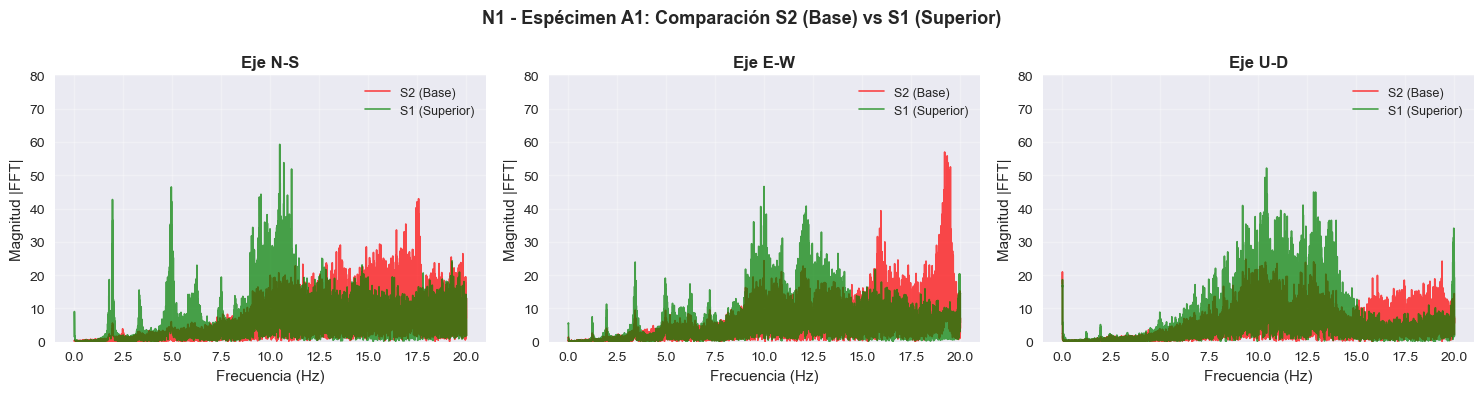

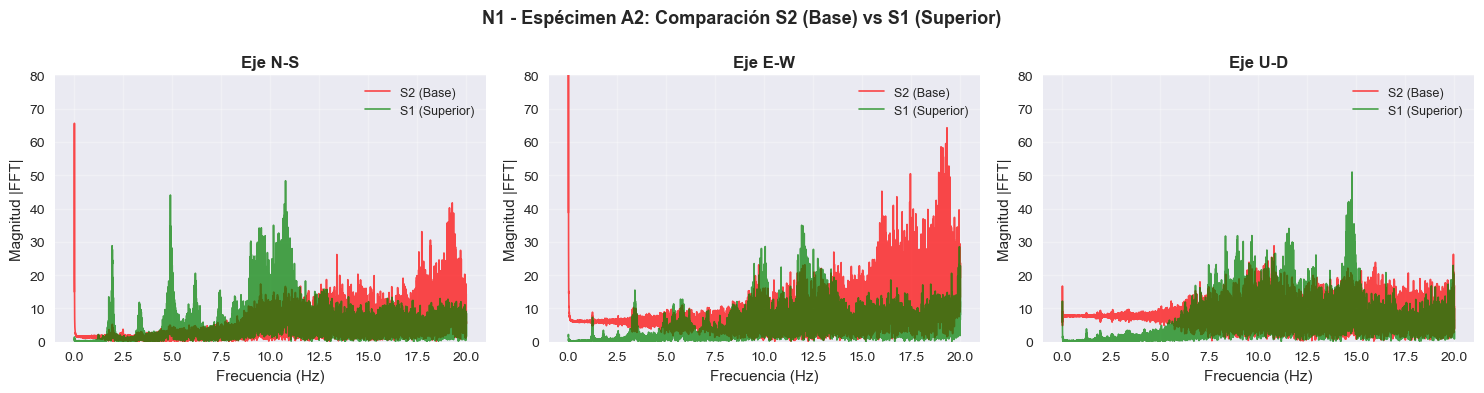

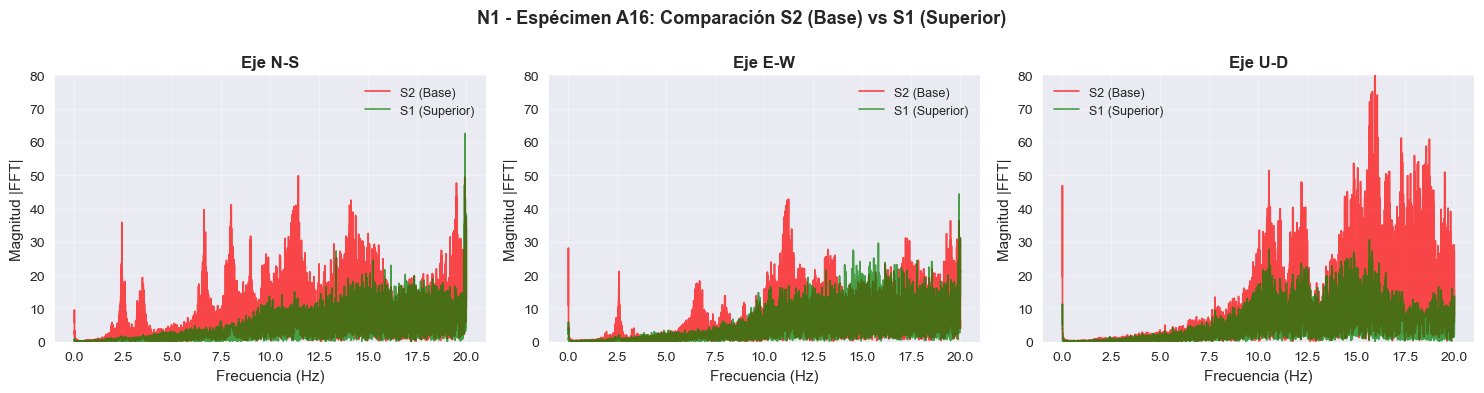

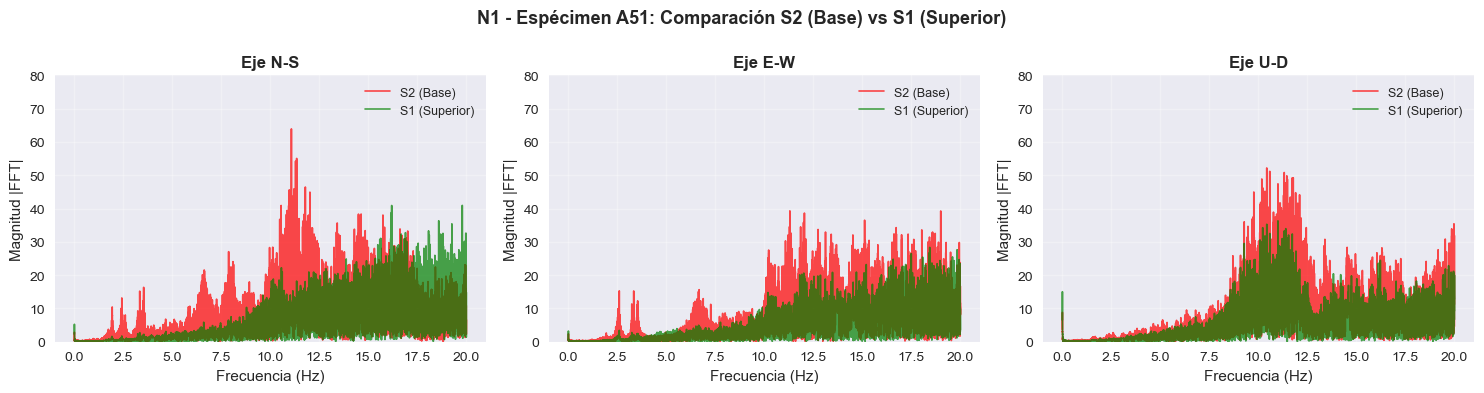

In [385]:
# Visualizar 3 ejemplos de N1
# specimens_n1 = get_specimens_by_damage(fft_data, 'N1', n=3)
specimens_n1 = get_specimens_by_id(fft_data, ['A1','A2','A16','A51']) # 2 primer dataset, 2 ultimo dataset
print(f"Especímenes N1 encontrados: {[s['specimen_id'] for s in specimens_n1]}\n")

for specimen in specimens_n1:
    plot_fft_specimen(specimen)

### Espectros N2 (Daño moderado)

Especímenes N2 encontrados: ['A8', 'A9', 'A23', 'A25']



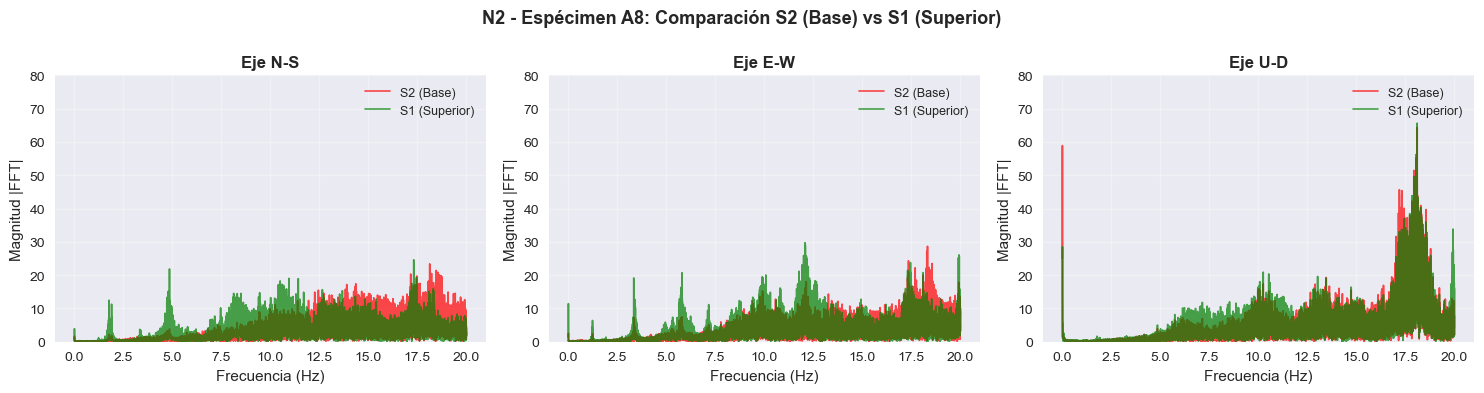

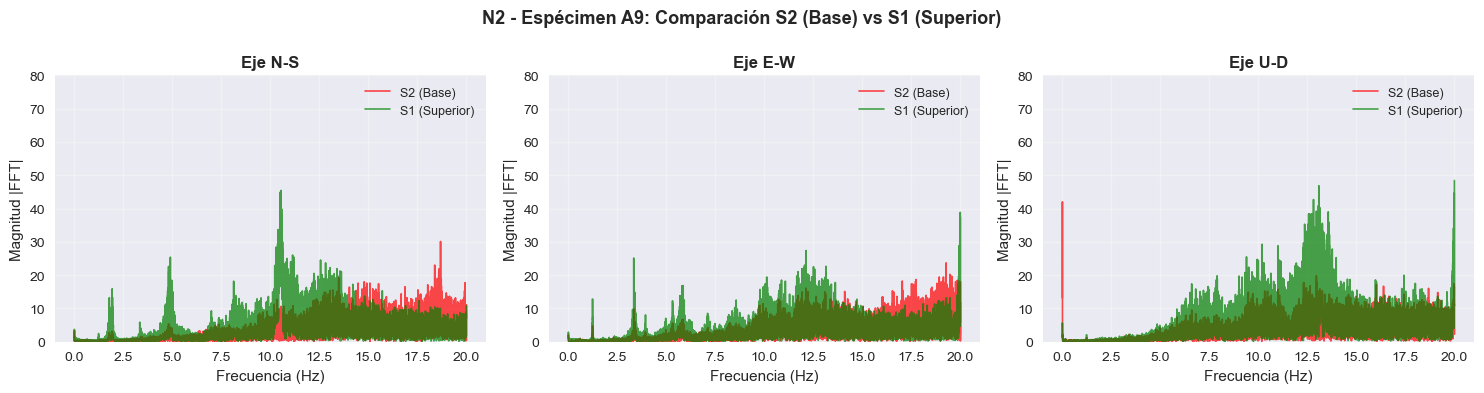

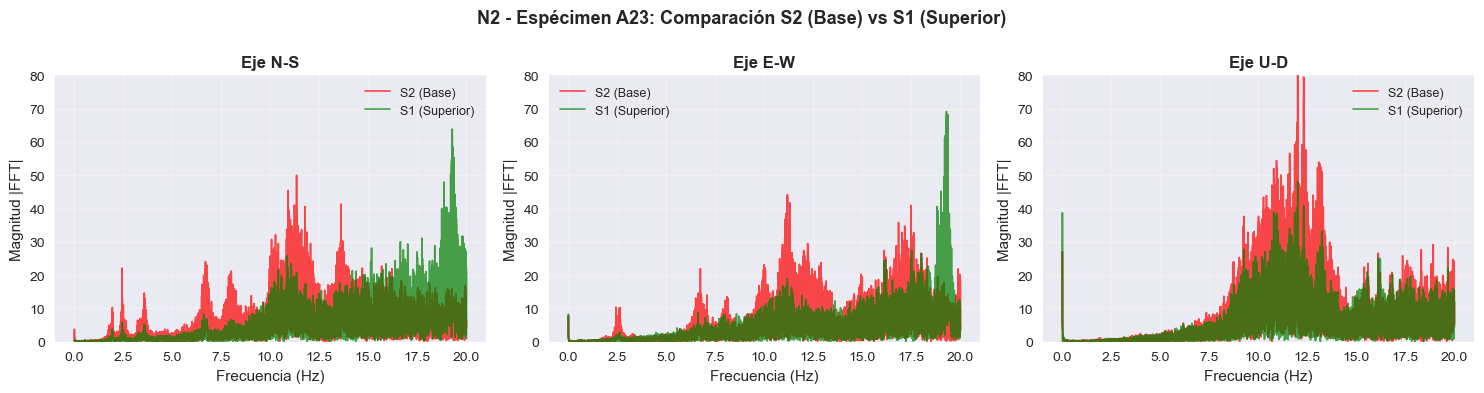

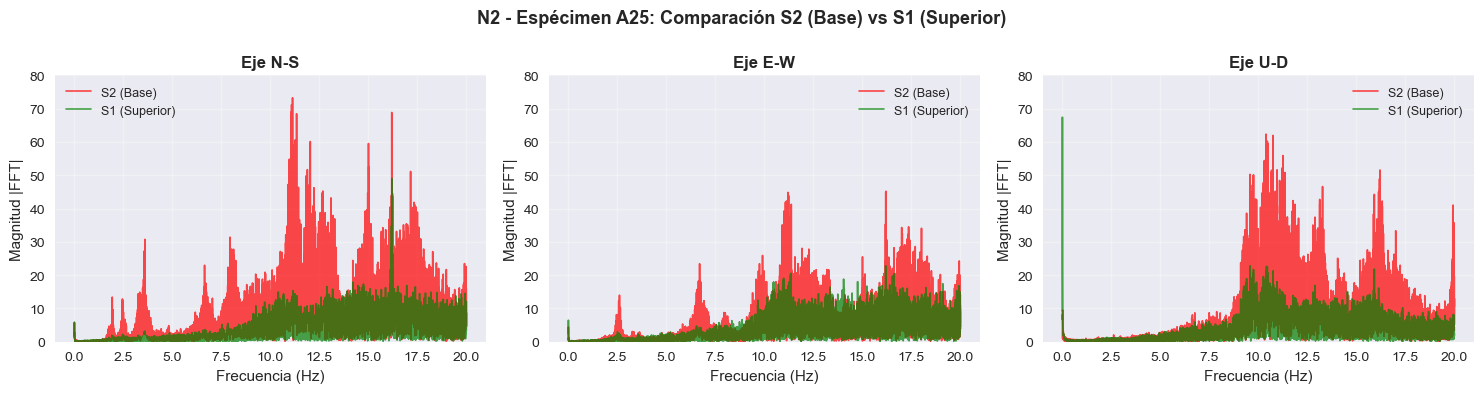

In [386]:
# Visualizar 3 ejemplos de N2
# specimens_n2 = get_specimens_by_damage(fft_data, 'N2', n=3)
specimens_n2 = get_specimens_by_id(fft_data, ['A8','A9','A23','A25']) # categorizados como N2 (2 primer dataset, 2 ultimo)
print(f"Especímenes N2 encontrados: {[s['specimen_id'] for s in specimens_n2]}\n")

for specimen in specimens_n2:
    plot_fft_specimen(specimen)

### Espectros N3 (Daño severo)

Especímenes N3 encontrados: ['A5', 'A6']



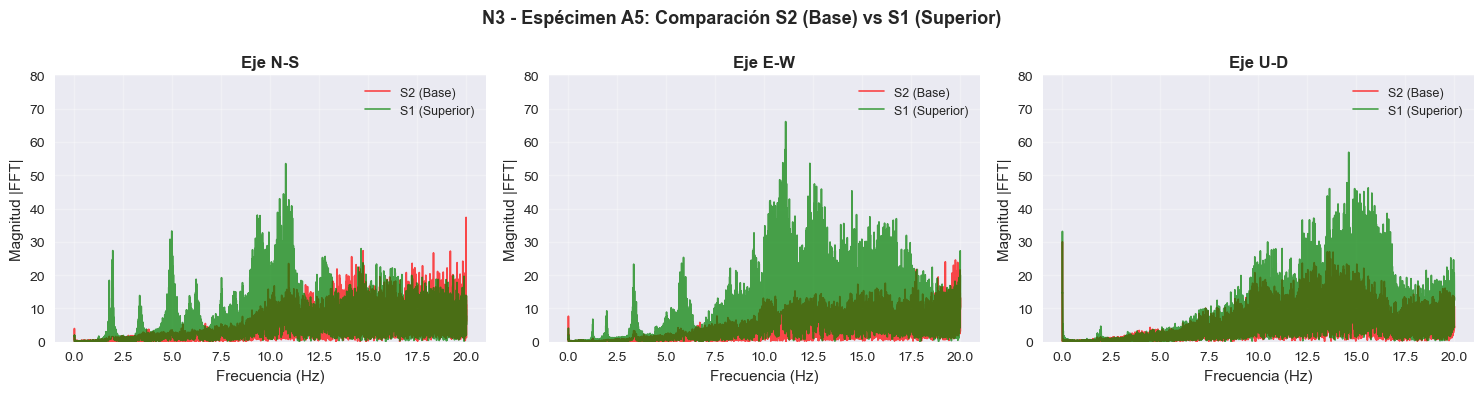

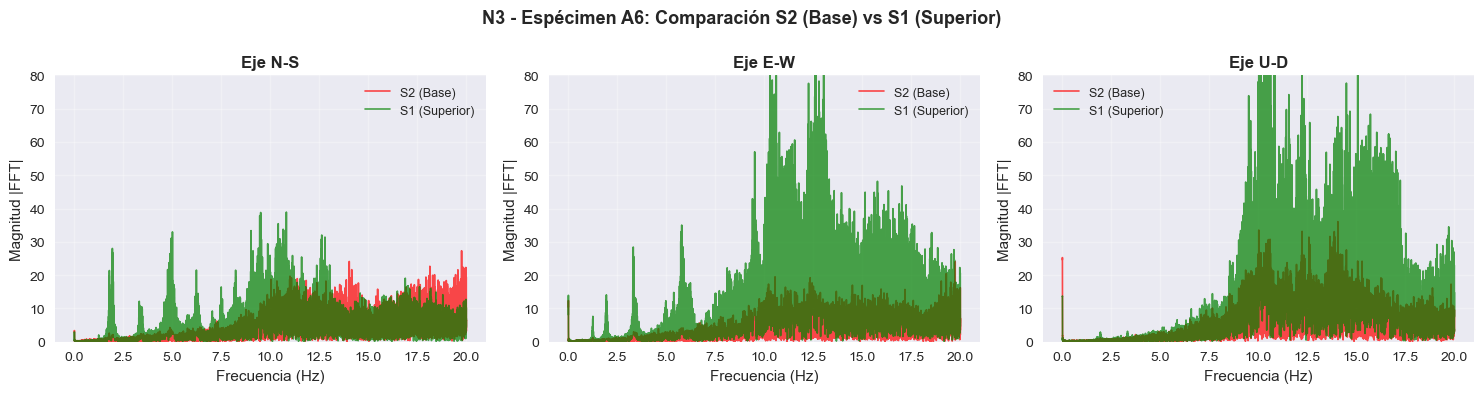

In [387]:
# Visualizar 3 ejemplos de N3
specimens_n3 = get_specimens_by_damage(fft_data, 'N3', n=3)
print(f"Especímenes N3 encontrados: {[s['specimen_id'] for s in specimens_n3]}\n")

for specimen in specimens_n3:
    plot_fft_specimen(specimen)

## 4. Visualización con Función de Transferencia y Diferencia Espectral

Analizamos la **relación entre S1 y S2**:
- **Ratio H(f) = |S1|/|S2|**: Función de transferencia
- **Diferencia Δ(f) = |S1| - |S2|**: Diferencia espectral

In [402]:
def plot_transfer_function(pair: dict, freq_max: float = 20.0, log_scale: bool = True, figsize: tuple = (15, 4)):
    """
    Plotea la Función de Transferencia H(f) = |S1(f)| / |S2(f)| para un espécimen.
    
    Args:
        pair: Diccionario con datos FFT del espécimen
        freq_max: Frecuencia máxima a mostrar (Hz)
        log_scale: Si True, usa escala logarítmica en eje Y
        figsize: Tamaño de la figura
    """
    specimen_id = pair['specimen_id']
    nivel = pair['nivel_dano']
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f'{nivel} - Espécimen {specimen_id}: Función de Transferencia H(f) = |S1|/|S2|', 
                 fontsize=13, fontweight='bold')
    
    axis_names = ['N-S', 'E-W', 'U-D']
    freqs = pair['fft_S2']['freqs']
    freq_mask = freqs <= freq_max
    
    for idx, axis_name in enumerate(axis_names):
        ax = axes[idx]
        mag_s2 = pair['fft_S2']['magnitudes'][:, idx]
        mag_s1 = pair['fft_S1']['magnitudes'][:, idx]
        
        # Evitar división por cero
        epsilon = 1e-10
        H_f = mag_s1 / (mag_s2 + epsilon)
        
        ax.plot(freqs[freq_mask], H_f[freq_mask], 
                color='purple', alpha=0.8, linewidth=0.8)
        
        # Línea de referencia H(f) = 1
        ax.axhline(y=1, color='yellow', linestyle='--', linewidth=2, label='H(f)=1')
        
        ax.set_xlabel('Frecuencia (Hz)')
        ax.set_ylabel('H(f) = |S1|/|S2|')
        ax.set_title(f'Eje {axis_name}', fontweight='bold')
        
        if log_scale:
            ax.set_yscale('log')
            ax.set_ylim(0.01, 100)  # Rango logarítmico
        else:
            ax.set_ylim(0, 10)
            
        ax.legend(fontsize=9, loc='upper right')
        ax.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.show()


def plot_spectral_difference(pair: dict, freq_max: float = 20.0, figsize: tuple = (15, 4)):
    """
    Plotea la Diferencia Espectral Δ(f) = |S1(f)| - |S2(f)| para un espécimen.
    
    Args:
        pair: Diccionario con datos FFT del espécimen
        freq_max: Frecuencia máxima a mostrar (Hz)
        figsize: Tamaño de la figura
    """
    specimen_id = pair['specimen_id']
    nivel = pair['nivel_dano']
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f'{nivel} - Espécimen {specimen_id}: Diferencia Espectral Δ(f) = |S1| - |S2|', 
                 fontsize=13, fontweight='bold')
    
    axis_names = ['N-S', 'E-W', 'U-D']
    freqs = pair['fft_S2']['freqs']
    freq_mask = freqs <= freq_max
    
    for idx, axis_name in enumerate(axis_names):
        ax = axes[idx]
        mag_s2 = pair['fft_S2']['magnitudes'][:, idx]
        mag_s1 = pair['fft_S1']['magnitudes'][:, idx]
        
        delta_f = mag_s1 - mag_s2
        
        # Plot con colores según signo
        ax.fill_between(freqs[freq_mask], 0, delta_f[freq_mask], 
                        where=(delta_f[freq_mask] >= 0),
                        color='red', alpha=0.5, label='S1 > S2 (amplificación)')
        ax.fill_between(freqs[freq_mask], 0, delta_f[freq_mask], 
                        where=(delta_f[freq_mask] < 0),
                        color='green', alpha=0.5, label='S1 < S2 (atenuación)')
        
        ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
        
        ax.set_xlabel('Frecuencia (Hz)')
        ax.set_ylabel('Δ(f) = |S1| - |S2|')
        ax.set_title(f'Eje {axis_name}', fontweight='bold')
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


print("Funciones de análisis relacional definidas")

Funciones de análisis relacional definidas


### Función de Transferencia H(f)

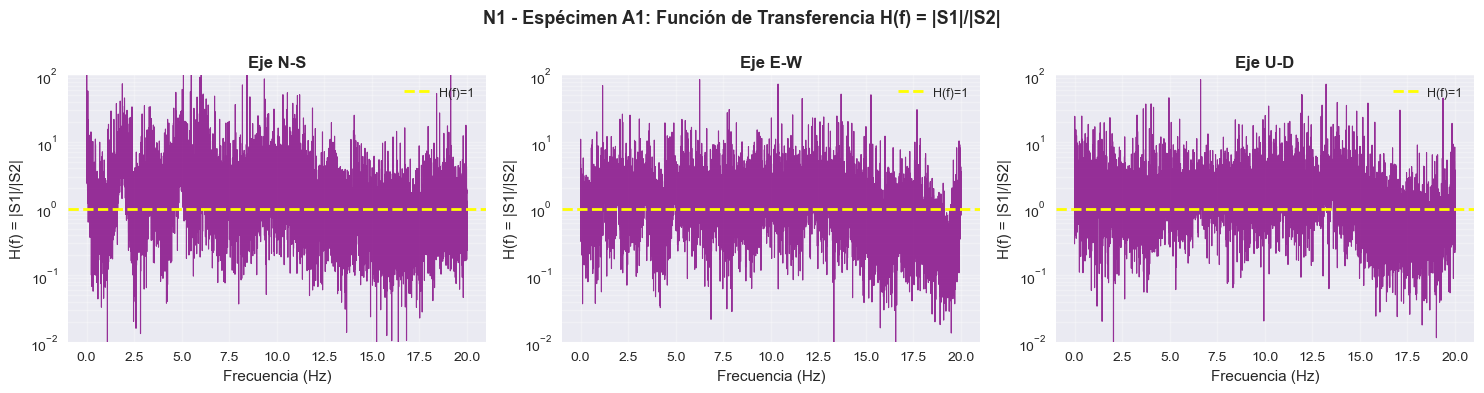

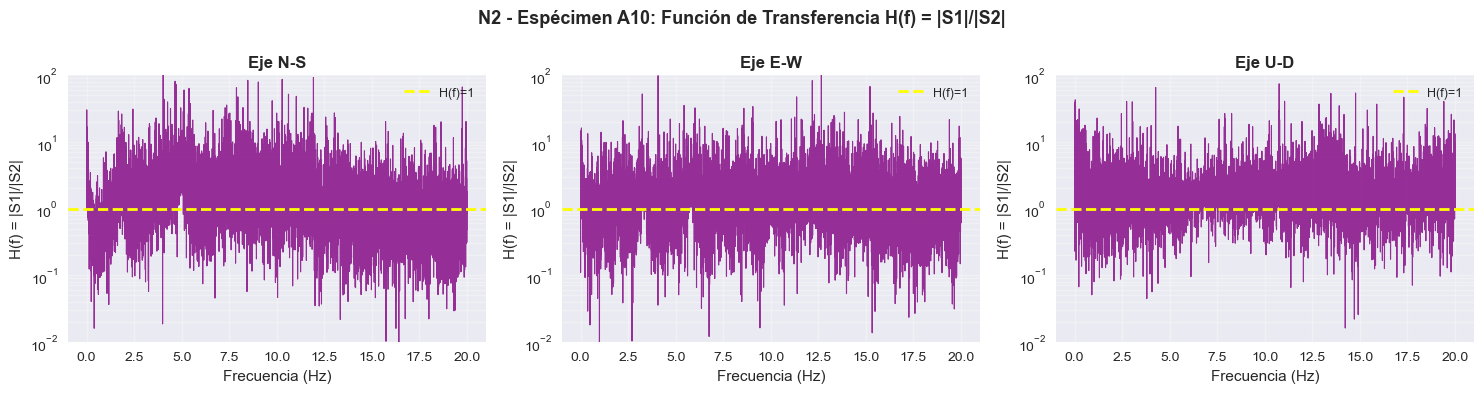

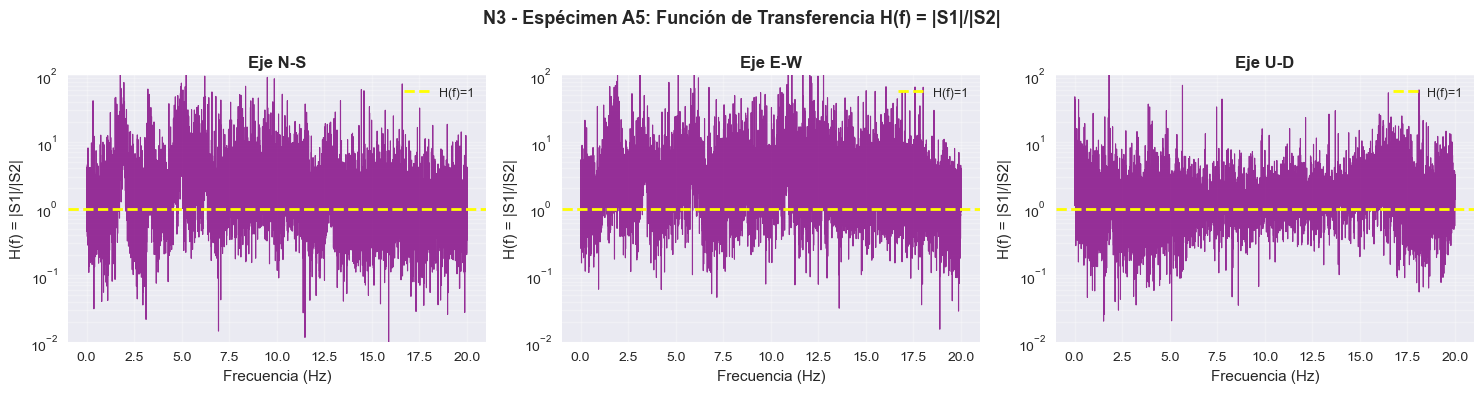

In [403]:
# H(f) para un espécimen de cada nivel
for nivel in ['N1', 'N2', 'N3']:
    specimens = get_specimens_by_damage(fft_data, nivel, n=1)
    if specimens:
        plot_transfer_function(specimens[0])

### Diferencia Espectral Δ(f)

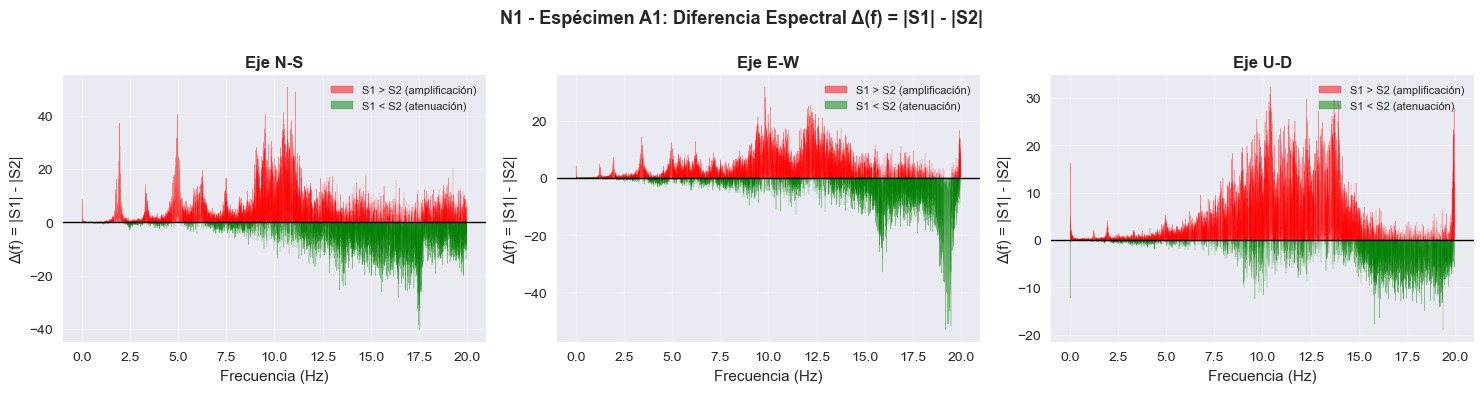

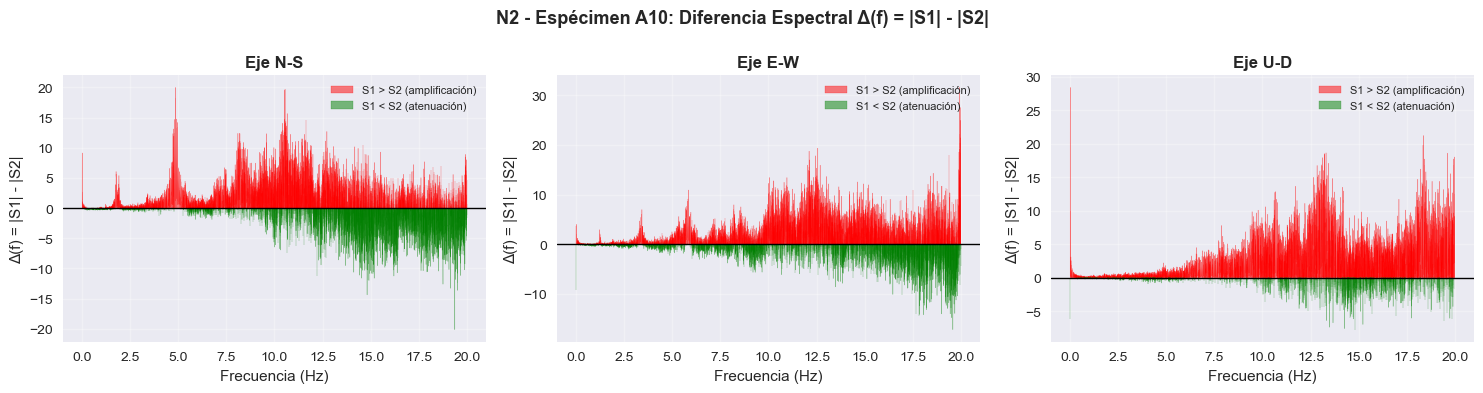

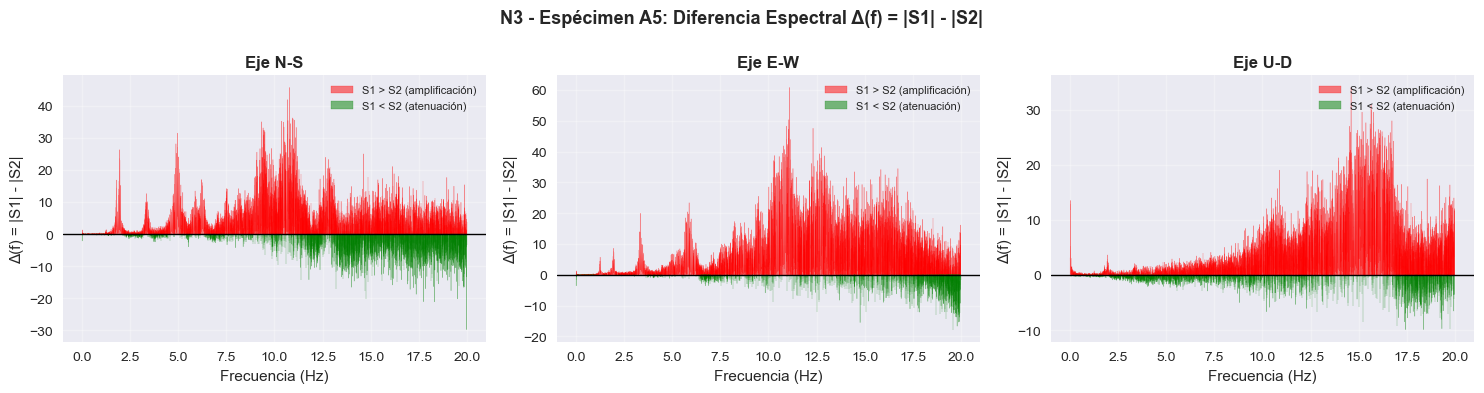

In [390]:
# Δ(f) para un espécimen de cada nivel
for nivel in ['N1', 'N2', 'N3']:
    specimens = get_specimens_by_damage(fft_data, nivel, n=1)
    if specimens:
        plot_spectral_difference(specimens[0])

## 5. Análisis de Clustering

Extraemos características espectrales y aplicamos K-Means para identificar agrupaciones naturales.

In [391]:
# Importar función de extracción de features
from clustering_utils import extract_simple_spectral_features

# Extraer características espectrales
# include_transfer_features=True agrega H(f) y Δ(f) → 36 features en lugar de 18
features_matrix, features_df, feature_names = extract_simple_spectral_features(
    fft_data=fft_data,
    freq_range=(0, 20),
    include_transfer_features=True  # Cambiar a False para usar solo features base
)

print(f"\n📊 Matriz de features lista para clustering:")
print(f"   Shape: {features_matrix.shape}")
print(f"   {features_matrix.shape[0]} especímenes × {features_matrix.shape[1]} características")

🔄 Extrayendo características espectrales...
   Rango de frecuencias: 0 - 20 Hz
   Include transfer features: True
   ✓ A1 (N1): 36 features extraídas
   ✓ A10 (N2): 36 features extraídas
   ✓ A11 (N2): 36 features extraídas
   ✓ A12 (N1): 36 features extraídas
   ✓ A13 (N1): 36 features extraídas
   ✓ A14 (N1): 36 features extraídas
   ✓ A15 (N1): 36 features extraídas
   ✓ A16 (N1): 36 features extraídas
   ✓ A17 (N1): 36 features extraídas
   ✓ A18 (N1): 36 features extraídas
   ✓ A19 (N1): 36 features extraídas
   ✓ A2 (N1): 36 features extraídas
   ✓ A20 (N1): 36 features extraídas
   ✓ A21 (N1): 36 features extraídas
   ✓ A22 (N1): 36 features extraídas
   ✓ A23 (N2): 36 features extraídas
   ✓ A24 (N1): 36 features extraídas
   ✓ A25 (N2): 36 features extraídas
   ✓ A26 (N1): 36 features extraídas
   ✓ A27 (N1): 36 features extraídas
   ✓ A28 (N1): 36 features extraídas
   ✓ A29 (N1): 36 features extraídas
   ✓ A3 (N1): 36 features extraídas
   ✓ A30 (N1): 36 features extraídas
 

In [392]:
# Inspeccionar el DataFrame de features
print("📋 PRIMERAS 5 FILAS DEL DATAFRAME DE FEATURES:")
print(features_df.head().to_string())

print("\n📊 ESTADÍSTICAS DESCRIPTIVAS:")
print(features_df[feature_names].describe())

📋 PRIMERAS 5 FILAS DEL DATAFRAME DE FEATURES:
  tipo nivel_dano specimen_id  freq_dom_S2_NS  freq_dom_S2_EW  freq_dom_S2_UD  freq_dom_S1_NS  freq_dom_S1_EW  freq_dom_S1_UD  mag_peak_S2_NS  mag_peak_S2_EW  mag_peak_S2_UD  mag_peak_S1_NS  mag_peak_S1_EW  mag_peak_S1_UD  energy_S2_NS  energy_S2_EW  energy_S2_UD  energy_S1_NS  energy_S1_EW  energy_S1_UD  ratio_mean_NS  ratio_std_NS  ratio_max_NS  ratio_mean_EW  ratio_std_EW  ratio_max_EW  ratio_mean_UD  ratio_std_UD  ratio_max_UD  delta_mean_NS  delta_std_NS  delta_energy_NS  delta_mean_EW  delta_std_EW  delta_energy_EW  delta_mean_UD  delta_std_UD  delta_energy_UD
0    B         N1          A1       17.561667       19.196667        9.358333       42.941020       56.966391       24.805240       12.923618       12.784725        7.147410       10.476667        9.981667       10.418333     59.262653     46.603066     52.144062     15.425291     11.921611     17.036949       2.304585      4.750007    161.740705       1.618681      2.367416    

### Características Extraídas

Cada señal (S2 y S1) tiene **3 ejes de aceleración**: N-S, E-W, U-D.

#### Features Base (18 total)
Por cada sensor (S2, S1) y eje se extraen:

| Feature | Descripción |
|---------|-------------|
| `freq_dom` | Frecuencia del pico máximo |
| `mag_peak` | Magnitud del pico máximo |
| `energy` | Energía total (0-20 Hz) |

#### Features de Transferencia (18 adicionales)
Cuando `include_transfer_features=True`, se agregan features de la **relación S1/S2**:

| Feature | Fórmula | Descripción |
|---------|---------|-------------|
| `ratio_mean` | mean(S1/S2) | Media de la función de transferencia |
| `ratio_std` | std(S1/S2) | Variabilidad de la transferencia |
| `ratio_max` | max(S1/S2) | Pico máximo de amplificación |
| `delta_mean` | mean(S1-S2) | Media de la diferencia espectral |
| `delta_std` | std(S1-S2) | Variabilidad de la diferencia |
| `delta_energy` | sum(\|S1-S2\|) | Energía de la diferencia |

**Total:** 18 base + 18 transferencia = **36 features** (con `include_transfer_features=True`)

### Normalización de Features

Antes de aplicar clustering, necesitamos **normalizar** las características porque tienen escalas muy diferentes:
- Frecuencias: 0-20 Hz
- Magnitudes: pueden variar en varios órdenes de magnitud
- Energía: valores muy grandes

Usaremos **StandardScaler** (z-score normalization) para que todas las features tengan media=0 y std=1.

In [393]:
from sklearn.preprocessing import StandardScaler

# Normalizar features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_matrix)

print("📊 Features normalizadas:")
print(f"   Shape: {features_normalized.shape}")
print(f"   Media por feature: {features_normalized.mean(axis=0).mean():.6f} (≈0)")
print(f"   Std por feature: {features_normalized.std(axis=0).mean():.6f} (≈1)")
print(f"\n✅ Normalización completada")

📊 Features normalizadas:
   Shape: (51, 36)
   Media por feature: -0.000000 (≈0)
   Std por feature: 1.000000 (≈1)

✅ Normalización completada


### Método del Codo

Técnica para determinar el número óptimo de clusters (k):
- Ejecuta K-Means para diferentes valores de k
- Calcula la inercia (WCSS) para cada k
- Busca el "codo": punto donde la inercia deja de disminuir significativamente

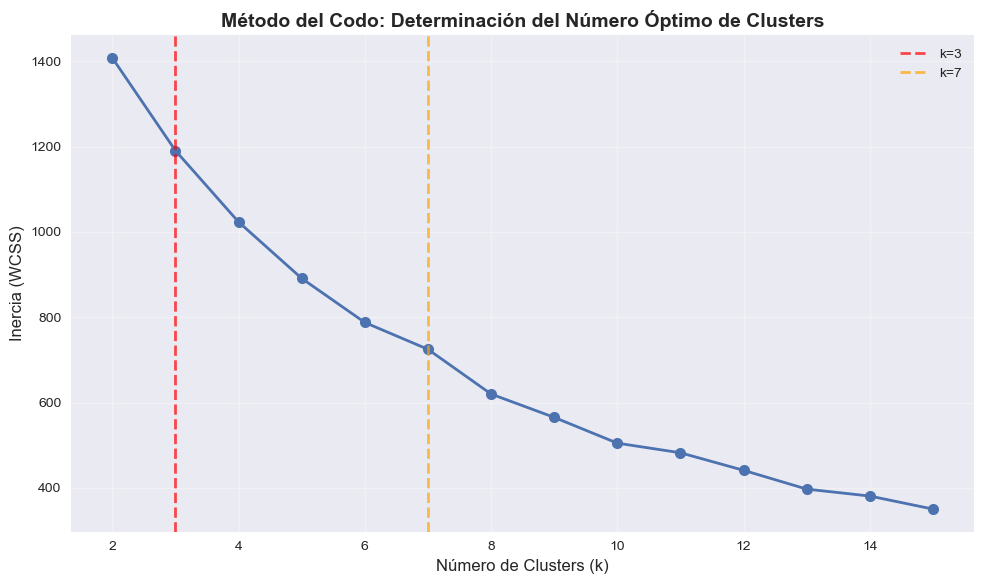

✅ Método del codo completado

📊 Interpretación:
   • Busca el 'codo' donde la inercia deja de disminuir significativamente
   • El codo indica el número óptimo de clusters
   • Inercia para k=3: 1190.73
   • Inercia para k=7: 725.00


In [394]:
from sklearn.cluster import KMeans

# Calcular inercia para diferentes valores de k
k_range = range(2, 16)
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_normalized)
    inertias.append(kmeans.inertia_)

# Graficar método del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
plt.axvline(x=3, color='red', linestyle='--', linewidth=2, alpha=0.7, label='k=3')
plt.axvline(x=7, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='k=7')
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inercia (WCSS)', fontsize=12)
plt.title('Método del Codo: Determinación del Número Óptimo de Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("✅ Método del codo completado")
print("\n📊 Interpretación:")
print("   • Busca el 'codo' donde la inercia deja de disminuir significativamente")
print("   • El codo indica el número óptimo de clusters")
print(f"   • Inercia para k=3: {inertias[1]:.2f}")
print(f"   • Inercia para k=7: {inertias[5]:.2f}")

### Reducción de Dimensionalidad (PCA)

Aplicamos PCA para visualizar los datapoints en 2D. Primero evaluamos cuánta varianza captura cada componente.

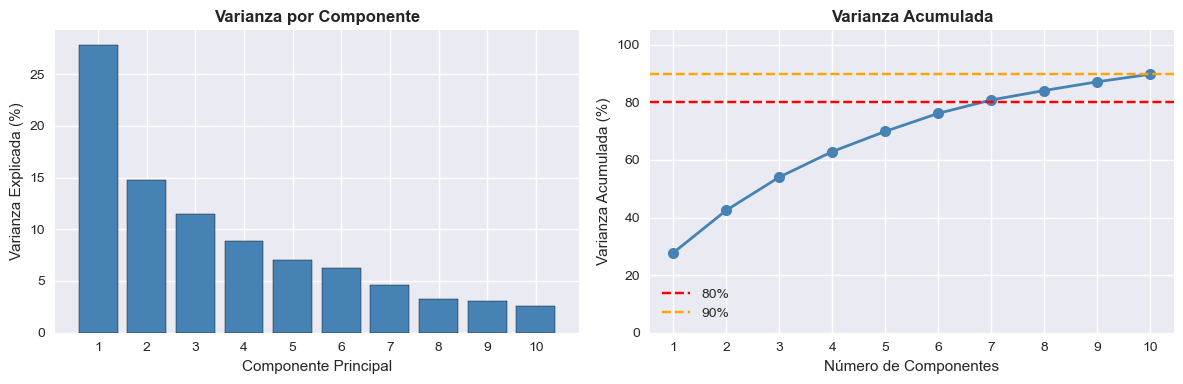

Varianza explicada:
  PC1:      27.8%
  PC1+PC2:  42.6%  (2D)
  PC1-3:    54.1%  (3D)

→ 3D agrega solo 11.5% más de varianza


In [395]:
# Scree Plot: Varianza explicada por componente
from sklearn.decomposition import PCA

pca_full = PCA().fit(features_normalized)
var_explicada = pca_full.explained_variance_ratio_
var_acumulada = np.cumsum(var_explicada)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Varianza por componente
n_components = min(10, len(var_explicada))
axes[0].bar(range(1, n_components + 1), var_explicada[:n_components] * 100, 
            color='steelblue', edgecolor='black')
axes[0].set_xlabel('Componente Principal')
axes[0].set_ylabel('Varianza Explicada (%)')
axes[0].set_title('Varianza por Componente', fontweight='bold')
axes[0].set_xticks(range(1, n_components + 1))

# Plot 2: Varianza acumulada
axes[1].plot(range(1, n_components + 1), var_acumulada[:n_components] * 100, 
             'o-', color='steelblue', linewidth=2, markersize=8)
axes[1].axhline(y=80, color='red', linestyle='--', label='80%')
axes[1].axhline(y=90, color='orange', linestyle='--', label='90%')
axes[1].set_xlabel('Número de Componentes')
axes[1].set_ylabel('Varianza Acumulada (%)')
axes[1].set_title('Varianza Acumulada', fontweight='bold')
axes[1].set_xticks(range(1, n_components + 1))
axes[1].legend()
axes[1].set_ylim(0, 105)

plt.tight_layout()
plt.show()

# Resumen
print(f"Varianza explicada:")
print(f"  PC1:     {var_explicada[0]*100:>5.1f}%")
print(f"  PC1+PC2: {var_acumulada[1]*100:>5.1f}%  (2D)")
print(f"  PC1-3:   {var_acumulada[2]*100:>5.1f}%  (3D)")
print(f"\n→ 3D agrega solo {(var_acumulada[2]-var_acumulada[1])*100:.1f}% más de varianza")

**Interpretación:**
- La varianza está muy distribuida: se necesitan ~7 componentes para 80%
- PC3 solo agrega ~11% adicional sobre PC1+PC2
- La visualización 2D captura ~43% de la varianza total
- No se justifica usar 3D por la complejidad visual vs. ganancia marginal

In [396]:
from sklearn.decomposition import PCA

# Aplicar PCA para reducir a 2D
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_normalized)

print("📊 PCA aplicado:")
print(f"   Shape original: {features_normalized.shape}")
print(f"   Shape reducida: {features_pca.shape}")
print(f"\n📈 Varianza explicada por componente:")
print(f"   PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"   PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"   Total: {pca.explained_variance_ratio_.sum():.2%}")
print(f"\n✅ Reducción de dimensionalidad completada")

📊 PCA aplicado:
   Shape original: (51, 36)
   Shape reducida: (51, 2)

📈 Varianza explicada por componente:
   PC1: 27.83%
   PC2: 14.74%
   Total: 42.57%

✅ Reducción de dimensionalidad completada


### Visualización de Datos Reales

Distribución de especímenes en espacio PCA, coloreados por etiqueta real (N1, N2, N3).

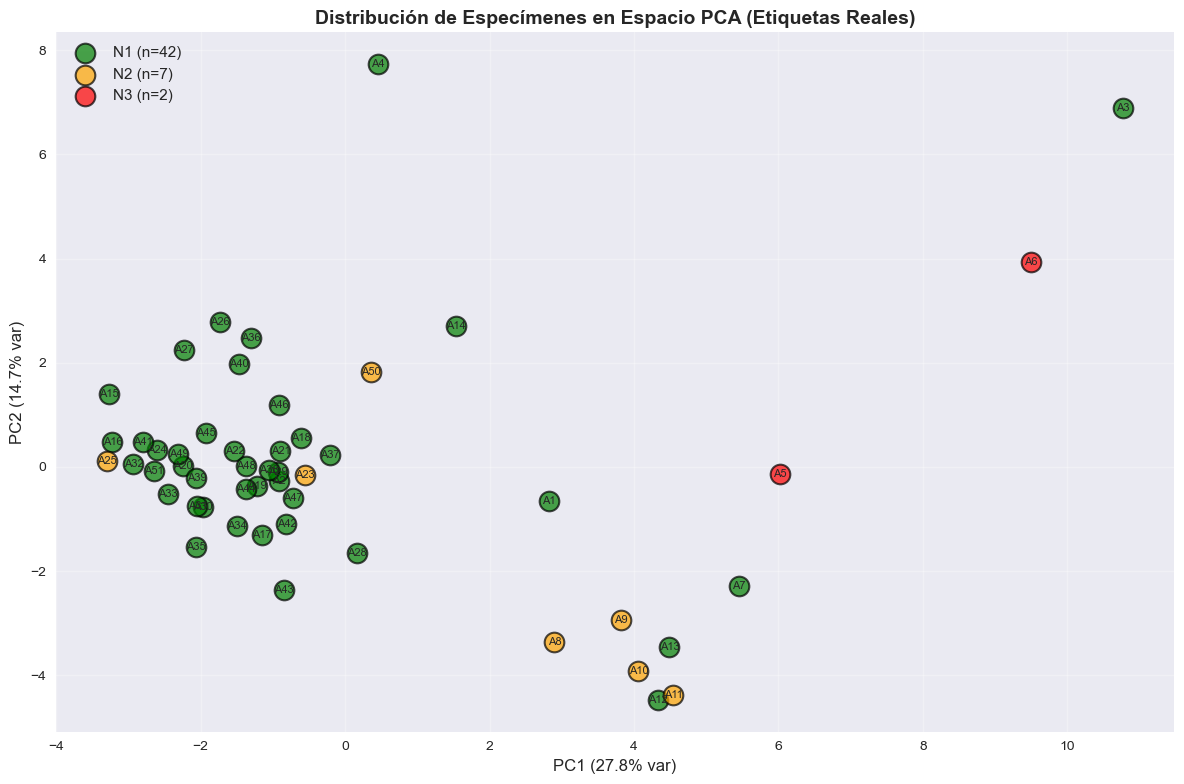

✅ Visualización completada

📊 OBSERVACIONES:
   • ¿Se agrupan naturalmente los especímenes del mismo nivel de daño?
   • ¿Hay solapamiento entre N1, N2, N3?
   • ¿Se observan outliers?


In [397]:
# Crear visualización de los datos reales en espacio PCA
fig, ax = plt.subplots(figsize=(12, 8))

# Colores por nivel de daño (incluyendo Sin_etiqueta)
colors = {'N1': 'green', 'N2': 'orange', 'N3': 'red', 'Sin_etiqueta': 'gray'}
labels_real = features_df['nivel_dano'].values
specimen_ids = features_df['specimen_id'].values

for nivel in ['N1', 'N2', 'N3', 'Sin_etiqueta']:
    mask = labels_real == nivel
    if mask.sum() == 0:  # Skip si no hay especímenes de este tipo
        continue
    
    ax.scatter(
        features_pca[mask, 0],
        features_pca[mask, 1],
        c=colors[nivel],
        label=f'{nivel} (n={mask.sum()})',
        s=200,
        alpha=0.7,
        edgecolors='black',
        linewidths=1.5
    )
    
    # Anotar IDs de especímenes
    for i, specimen_id in enumerate(specimen_ids[mask]):
        ax.annotate(
            specimen_id,
            (features_pca[mask, 0][i], features_pca[mask, 1][i]),
            fontsize=8,
            ha='center',
            va='center'
        )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
ax.set_title('Distribución de Especímenes en Espacio PCA (Etiquetas Reales)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualización completada")
print("\n📊 OBSERVACIONES:")
print("   • ¿Se agrupan naturalmente los especímenes del mismo nivel de daño?")
print("   • ¿Hay solapamiento entre N1, N2, N3?")
print("   • ¿Se observan outliers?")

### Aplicación de K-Means (k=3)

Aplicamos K-Means con k=3 clusters para evaluar si descubre grupos que coincidan con N1, N2, N3.

In [398]:
from sklearn.cluster import KMeans

# Aplicar K-Means con k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_normalized)

# Agregar etiquetas de cluster al DataFrame
features_df['cluster'] = cluster_labels

print("📊 K-Means aplicado:")
print(f"   Número de clusters: 3")
print(f"   Inercia (within-cluster sum of squares): {kmeans.inertia_:.2f}")
print(f"\n📈 Distribución de especímenes por cluster:")
print(features_df['cluster'].value_counts().sort_index())

print(f"\n📋 Comparación Cluster vs Nivel de Daño Real:")
comparison = pd.crosstab(features_df['nivel_dano'], features_df['cluster'], 
                         rownames=['Nivel Daño'], colnames=['Cluster'])
print(comparison)

📊 K-Means aplicado:
   Número de clusters: 3
   Inercia (within-cluster sum of squares): 1190.73

📈 Distribución de especímenes por cluster:
cluster
0     2
1    40
2     9
Name: count, dtype: int64

📋 Comparación Cluster vs Nivel de Daño Real:
Cluster     0   1  2
Nivel Daño          
N1          1  37  4
N2          0   3  4
N3          1   0  1


### Visualización de Clusters

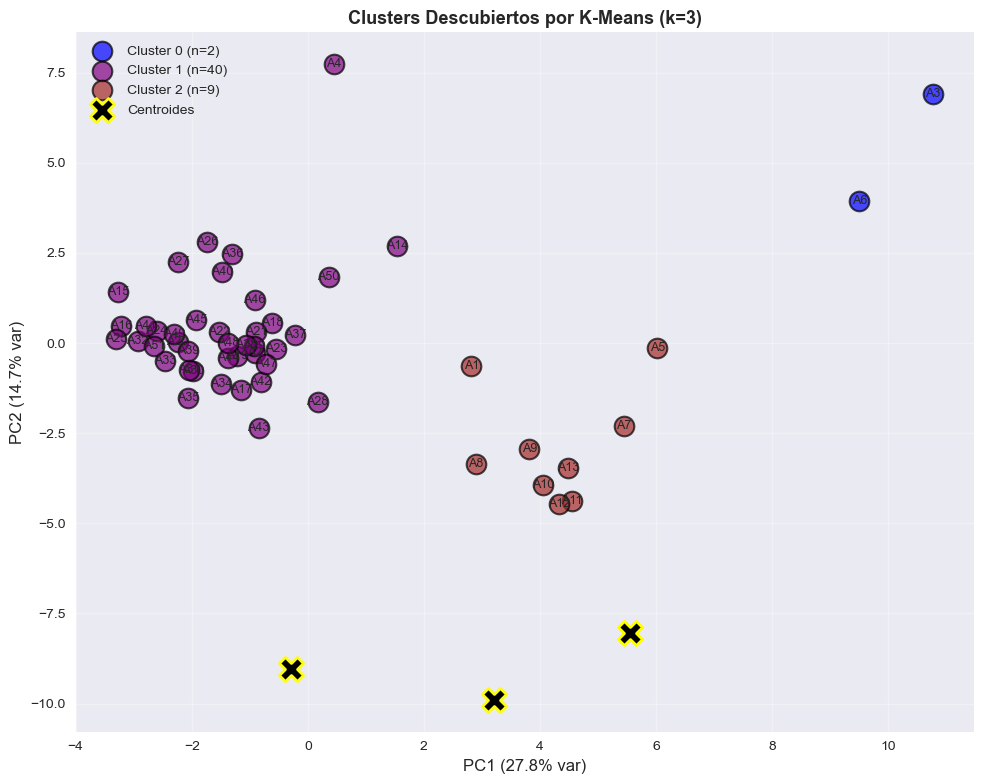

In [399]:
# Visualización: Clusters descubiertos por K-Means
fig, ax = plt.subplots(figsize=(10, 8))

cluster_colors = {0: 'blue', 1: 'purple', 2: 'brown'}

for cluster_id in range(3):
    mask = cluster_labels == cluster_id
    ax.scatter(
        features_pca[mask, 0],
        features_pca[mask, 1],
        c=cluster_colors[cluster_id],
        label=f'Cluster {cluster_id} (n={mask.sum()})',
        s=200,
        alpha=0.7,
        edgecolors='black',
        linewidths=1.5
    )
    
    # Anotar IDs
    for i, specimen_id in enumerate(specimen_ids[mask]):
        ax.annotate(
            specimen_id,
            (features_pca[mask, 0][i], features_pca[mask, 1][i]),
            fontsize=9,
            ha='center',
            va='center'
        )

# Plot centroides
centroids_pca = pca.transform(scaler.transform(kmeans.cluster_centers_))
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
           c='black', marker='X', s=300, 
           edgecolors='yellow', linewidths=2,
           label='Centroides', zorder=10)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
ax.set_title('Clusters Descubiertos por K-Means (k=3)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Métricas de Evaluación

In [400]:
from clustering_utils import evaluate_clustering

metrics = evaluate_clustering(
    features=features_normalized,
    cluster_labels=cluster_labels,
    labels_real=labels_real,
    kmeans_model=kmeans,
    experiment_name="FFT + K-Means (k=3) con transfer features"
)

📊 MÉTRICAS: FFT + K-Means (k=3) con transfer features

🔹 Intrínsecas:
   Inertia:              1190.73
   Silhouette:            0.3123  [-1, 1] ↑
   Davies-Bouldin:        1.1776  [0, ∞) ↓
   Calinski-Harabasz:      13.01  [0, ∞) ↑

🔹 Extrínsecas (51/51 con etiqueta):
   ARI:                   0.4053  [-1, 1] ↑
   NMI:                   0.2588  [0, 1] ↑
   Homogeneity:           0.2736  [0, 1] ↑
   Completeness:          0.2455  [0, 1] ↑
   V-Measure:             0.2588  [0, 1] ↑


### Registro del Experimento

Registramos métricas y metadata en CSV para análisis comparativo.

In [401]:
# Registrar experimento en CSV
logger.log_experiment(
    experiment_id="fft_kmeans_k3_transfer",
    notebook_name="2_clustering_fft_kmeans",
    algorithm="kmeans",
    frequency_transform="fft",
    n_clusters=3,
    pca_dims=2,
    feature_set="spectral_with_transfer",
    
    # Métricas intrínsecas (desde dict metrics)
    inertia=metrics.get('inertia'),
    silhouette_score=metrics.get('silhouette'),
    davies_bouldin_index=metrics.get('davies_bouldin'),
    calinski_harabasz_score=metrics.get('calinski'),
    
    # Métricas extrínsecas
    adjusted_rand_index=metrics.get('ari'),
    normalized_mutual_info=metrics.get('nmi'),
    homogeneity=metrics.get('homogeneity'),
    completeness=metrics.get('completeness'),
    v_measure=metrics.get('v_measure'),
    
    # Metadata adicional
    n_samples=len(features_normalized),
    n_features=features_normalized.shape[1],
    notes="FFT + features espectrales + transfer features (ratio, delta) + K-Means k=3"
)

print(f"\n✅ Experimento registrado en: {RESULTS_FILE}")

🔄 Experimento actualizado: 2_clustering_fft_kmeans | kmeans | fft (ID: fft_kmeans_k3_transfer)

✅ Experimento registrado en: clustering_experiments.csv
